In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
import warnings
import numpy as np

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX


warnings.simplefilter("ignore")

df = pd.read_excel('HS861M_2010.xlsx', header = [0,1,2])

In [28]:
hourly_power_df = pd.read_excel('ERCOT_hourly/Native_Load_2025.xlsx')
hourly_power_df = hourly_power_df.set_index('Hour Ending')
s = hourly_power_df['ERCOT'].copy()

def clean_hour_ending(date_str):

    date_part, time_part = date_str.split(' ')
    if time_part == '24:00':
        return pd.to_datetime(date_part) + pd.Timedelta(days=1)
    else:
        return pd.to_datetime(date_str)


hourly_power_df = hourly_power_df.sort_index()


In [29]:

# ==========================================
# 1. PLOTTING (With Plotly)
# ==========================================
fig = go.Figure()

# Trace 1: Hourly Load (Raw Data)
fig.add_trace(go.Scatter(
    x=hourly_power_df.index,
    y=hourly_power_df['ERCOT'],
    mode='lines',
    name='Hourly Load',
    line=dict(color='#1f77b4', width=1),
    opacity=0.7
))

# Trace 2: Rolling Average (Trend)
rolling_mean = hourly_power_df['ERCOT'].rolling(window=24).mean()
fig.add_trace(go.Scatter(
    x=hourly_power_df.index,
    y=rolling_mean,
    mode='lines',
    name='24h Moving Average',
    line=dict(color='#d62728', width=2)
))

# Update Layout
fig.update_layout(
    title='ERCOT Power Consumption (2025)',
    xaxis_title='Date',
    yaxis_title='Load (MW)',
    template='plotly_white',
    hovermode='x unified',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)
fig.show()

print("Interactive plot generated successfully.")

Interactive plot generated successfully.


In [30]:
def join_header(tup):

    parts = [str(x).strip() for x in tup if pd.notna(x) and str(x).strip() != ""]
    return " ".join(parts)

df.columns = df.columns.map(join_header)

In [31]:
new_first4 = ["Year", "Month", "State", "Data Status"]

df.columns = new_first4 + list(df.columns[4:])

df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(r"[ /]+", "_", regex=True)
)

In [32]:
TX_consumption = df[df['state'] == 'TX']
TX_consumption.to_csv('TX_consumption.csv')
TX_consumption.reset_index()

,index,year,month,state,data_status,residential_revenue_thousand_dollars,residential_sales_megawatthours,residential_customers_count,residential_price_cents_kwh,commercial_revenue_thousand_dollars,...,industrial_customers_count,industrial_price_cents_kwh,transportation_revenue_thousand_dollars,transportation_sales_megawatthours,transportation_customers_count,transportation_price_cents_kwh,total_revenue_thousand_dollars,total_sales_megawatthours,total_customers_count,total_price_cents_kwh
0,43,2025,9.0,TX,Preliminary,2629847.9,16606481.0,12700866.0,15.84,1368080.5,...,405249.0,6.74,44.79,1193.75,3.0,3.75,5015245.2,46725113.0,14661957.0,10.73
1,94,2025,8.0,TX,Preliminary,3053103.5,19766971.0,12861831.0,15.45,1494938.3,...,407382.0,6.57,40.42,1074.91,3.0,3.76,5582804.1,51982879.0,14856099.0,10.74
2,145,2025,7.0,TX,Preliminary,2938121.0,19128723.0,12745852.0,15.36,1462019.2,...,410176.0,6.60,38.97,1032.58,3.0,3.77,5436155.5,51021948.0,14682811.0,10.65
3,196,2025,6.0,TX,Preliminary,2505083.5,16448338.0,12731147.0,15.23,1281589.9,...,406727.0,6.34,36.05,936.69,3.0,3.85,4725264.4,46151720.0,14663263.0,10.24
4,247,2025,5.0,TX,Preliminary,2009551.6,12975735.0,12680933.0,15.49,1203890.6,...,395651.0,6.63,33.73,869.51,3.0,3.88,4146770.7,40568903.0,14604052.0,10.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,9427,2010,5.0,TX,Final,1115313.0,9338767.0,9498989.0,11.94,887693.0,...,127017.0,6.40,586.00,5815.00,3.0,10.08,2533080.0,27222961.0,11078341.0,9.30
185,9478,2010,4.0,TX,Final,939081.0,7745987.0,9495461.0,12.12,849268.0,...,126661.0,6.48,589.00,6111.00,3.0,9.64,2292337.0,24541760.0,11079906.0,9.34
186,9529,2010,3.0,TX,Final,1099768.0,9557712.0,9491323.0,11.51,879323.0,...,124858.0,6.56,592.00,6189.00,3.0,9.57,2501621.0,26681477.0,11079822.0,9.38
187,9580,2010,2.0,TX,Final,1208908.0,10656540.0,9442046.0,11.34,829689.0,...,123697.0,6.68,531.00,5512.00,3.0,9.63,2516055.0,26517691.0,11020940.0,9.49


In [33]:
df = pd.read_csv('TX_consumption.csv')
df['Date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df = df.sort_values('Date').set_index('Date')

sectors = ['residential', 'commercial', 'industrial', 'transportation']


In [34]:
#We use exponential model here. We later try SARIMA and SARIMAX
def run_backtest(df, sector, split_date='2022-12-31'):

    cols = [f'{sector}_sales_megawatthours']
    data = df[cols].dropna()
    
    train = data[data.index <= split_date]
    test  = data[data.index > split_date]
    
    sales_col = cols[0]
    y_train = train[sales_col].astype(float)

    model = ExponentialSmoothing(
        y_train,
        trend="add",          
        seasonal='add', 
        seasonal_periods = 12,
        initialization_method="estimated"
    ).fit(optimized=True)

    fc_sales = model.forecast(len(test))

    fc_df = pd.DataFrame({sales_col: fc_sales}, index=test.index)
    
    actual = test[sales_col]
    pred   = fc_df[sales_col]
    
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mean_actual = actual.mean()
    error_pct = (rmse / mean_actual) * 100 if mean_actual != 0 else np.nan
    
    return {
        'rmse': rmse,
        'error_pct': error_pct,
        'train': train[sales_col],
        'test_actual': actual,
        'test_pred': pred
    }


Sector               | RMSE            | Error %    | Lags
------------------------------------------------------------
residential          |       1,162,030 |   8.18%
commercial           |         565,464 |   4.08%
industrial           |       1,480,881 |  10.54%
transportation       |          15,940 | 279.27%

Plot saved as 'backtest_2022_results.png'.


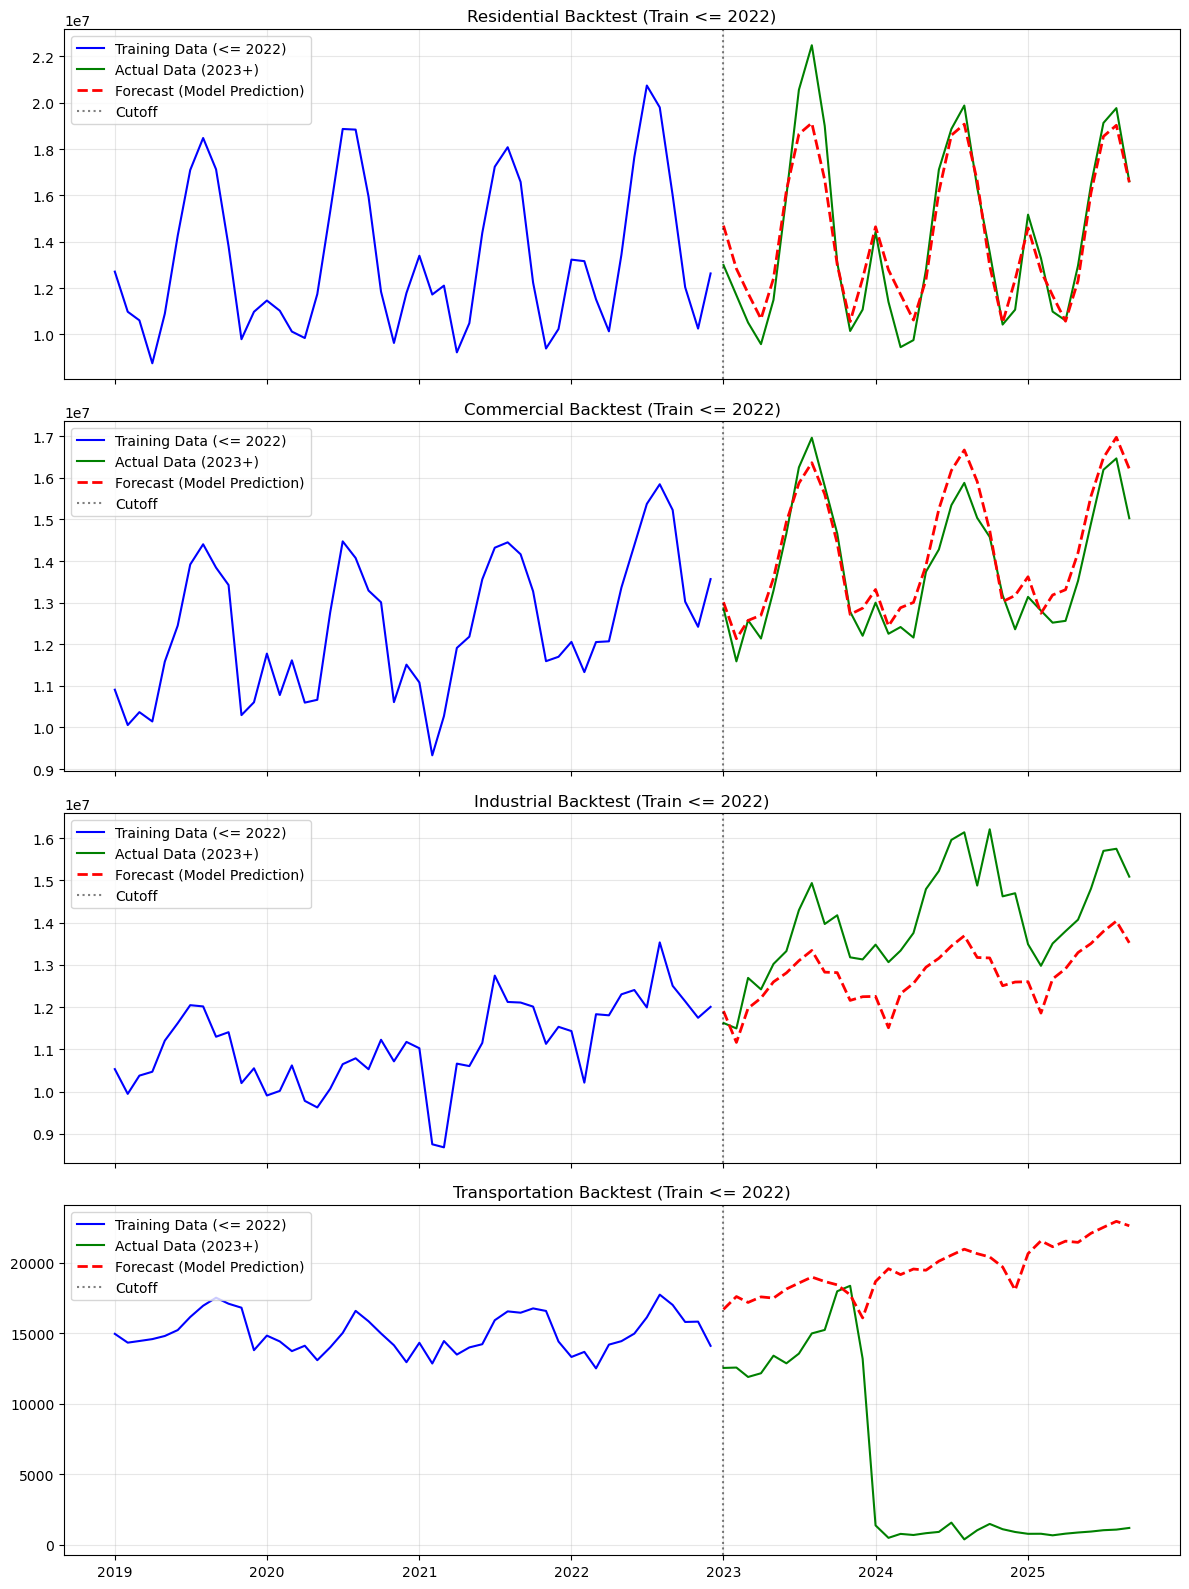

In [35]:

# 1. Execute and Plot
results_store = {}
print(f"{'Sector':<20} | {'RMSE':<15} | {'Error %':<10} | {'Lags'}")
print("-" * 60)

fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

for i, s in enumerate(sectors):
    res = run_backtest(df, s)
    ax = axes[i]
    
    if 'error' not in res:
        results_store[s] = res
        print(f"{s:<20} | {res['rmse']:15,.0f} | {res['error_pct']:6.2f}%")
        
        # Plot Logic
        # Show last 4 years of training data for context
        train_plot = res['train'].iloc[-48:] 
        
        ax.plot(train_plot.index, train_plot, label='Training Data (<= 2022)', color='blue')
        ax.plot(res['test_actual'].index, res['test_actual'], label='Actual Data (2023+)', color='green')
        ax.plot(res['test_pred'].index, res['test_pred'], label='Forecast (Model Prediction)', 
                color='red', linestyle='--', linewidth=2)
        
        # Add a vertical line at the cutoff
        ax.axvline(pd.Timestamp('2023-01-01'), color='black', linestyle=':', alpha=0.5, label='Cutoff')
        
        ax.set_title(f"{s.title()} Backtest (Train <= 2022)")
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3)
    else:
        print(f"{s:<20} | Failed: {res['error']}")
        ax.text(0.5, 0.5, 'Backtest Failed', ha='center', va='center')

plt.tight_layout()
plt.savefig('backtest_2022_results.png')
print("\nPlot saved as 'backtest_2022_results.png'.")

# 2. Save CSV Results
output_data = {}
for s in results_store:
    # Combine actual and pred into a frame
    sector_df = pd.DataFrame({
        f'{s}_actual': results_store[s]['test_actual'],
        f'{s}_predicted': results_store[s]['test_pred']
    })
    # Add to output dict (need to handle varying indices if any, though here they are same)
    for col in sector_df.columns:
        output_data[col] = sector_df[col]

final_df = pd.DataFrame(output_data)


In [36]:
df = pd.read_csv("TX_consumption.csv")

df["period"] = pd.to_datetime(
    dict(year=df["year"], month=df["month"].astype(int), day=1)
)
df = df.sort_values("period")

cutoff = pd.Timestamp("2023-01-01")
train_df = df[df["period"] <  cutoff].copy()   # ≤ 2022-12
test_df  = df[df["period"] >= cutoff].copy()   # ≥ 2023-01

y_col  = "residential_sales_megawatthours"
x_col  = "residential_price_cents_kwh"

y_train = (
    train_df.set_index("period")[y_col]
    .astype(float)
    .asfreq("MS")
)
y_test = (
    test_df.set_index("period")[y_col]
    .astype(float)
    .asfreq("MS")
)

X_train = (
    train_df.set_index("period")[x_col]
    .astype(float)
    .asfreq("MS")
)
X_test = (
    test_df.set_index("period")[x_col]
    .astype(float)
    .asfreq("MS")
)

assert (y_train.index == X_train.index).all()
assert (y_test.index  == X_test.index ).all()


order = (1, 1, 1)
seasonal_order = (0, 1, 1, 12)

model = SARIMAX(
    y_train,
    exog=X_train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
)
res = model.fit(disp=False)

steps = len(y_test)

fc = res.get_forecast(steps=steps, exog=X_test)
fc_mean = fc.predicted_mean
fc_ci   = fc.conf_int(alpha=0.05)

fc_mean = fc_mean.reindex(y_test.index)
fc_ci   = fc_ci.reindex(y_test.index)
lower = fc_ci.iloc[:, 0]
upper = fc_ci.iloc[:, 1]


def rmse(y_true, y_pred):
    diff = y_pred - y_true
    return np.sqrt(np.mean(diff**2))

def mape(y_true, y_pred, eps=1e-9):
    mask = np.abs(y_true) > eps
    return np.mean(np.abs((y_pred[mask] - y_true[mask]) / y_true[mask])) * 100.0

res_rmse = rmse(y_test.values, fc_mean.values)
res_mape = mape(y_test.values, fc_mean.values)

print(f"Residential + price  —  RMSE: {res_rmse:,.2f}   MAPE: {res_mape:5.2f}%")

# ========= 5) BUILD FORECAST DF (LIKE BEFORE) =========

residential_fc_df = pd.DataFrame({
    "period": y_test.index,
    "sector": "residential",
    "forecast_megawatthours": fc_mean.values,
    "lower_95": lower.values,
    "upper_95": upper.values,
    "actual_megawatthours": y_test.values,
    x_col: X_test.values,   # optional: keep the price used for exog
}).set_index("period")

print(residential_fc_df.head())

# Optionally save

Residential + price  —  RMSE: 7,359,054.70   MAPE: 50.55%
                 sector  forecast_megawatthours      lower_95      upper_95  \
period                                                                        
2023-01-01  residential            1.502235e+07  1.312168e+07  1.692302e+07   
2023-02-01  residential            1.447463e+07  1.193037e+07  1.701889e+07   
2023-03-01  residential            1.390037e+07  1.078074e+07  1.702001e+07   
2023-04-01  residential            1.346958e+07  9.895908e+06  1.704326e+07   
2023-05-01  residential            1.554615e+07  1.155506e+07  1.953724e+07   

            actual_megawatthours  residential_price_cents_kwh  
period                                                         
2023-01-01            12993366.0                        14.36  
2023-02-01            11690349.0                        14.72  
2023-03-01            10512638.0                        14.61  
2023-04-01             9579895.6                        14.36  
2023

In [37]:
FILE_PATH = 'TX_consumption.csv'
TRAIN_WINDOW = 80
FORECAST_HORIZON = 36
STEP_SIZE = 36
SECTORS = {
        "residential":    "residential_sales_megawatthours",
        "commercial":     "commercial_sales_megawatthours",
        "industrial":     "industrial_sales_megawatthours",
        "transportation": "transportation_sales_megawatthours",
    }

In [38]:
def load_and_prep_data(filepath):
    
    df = pd.read_csv(filepath)
    df["period"] = pd.to_datetime(dict(year=df["year"], month=df["month"].astype(int), day=1))
    df = df.sort_values("period").set_index("period")
    df = df.groupby(level=0).first().asfreq('MS')
    
    return df


def get_rolling_predictions(series, train_window, horizon, step):

    results = []
    total_len = len(series)
    start_idx = 0
    
    while True:
        end_train_idx = start_idx + train_window
        
        if end_train_idx >= total_len:
            break
            
        train_series = series.iloc[start_idx : end_train_idx]
        

        model = SARIMAX(
            train_series,
            order=(1, 1, 1),
            seasonal_order=(0, 1, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)
        
        # 3. Forecast
        forecast_obj = res.get_forecast(steps=horizon)
        forecast_series = forecast_obj.predicted_mean
        
        results.append({
            'cutoff_date': train_series.index[-1],
            'forecast_series': forecast_series
        })
            

        start_idx += step

    return results


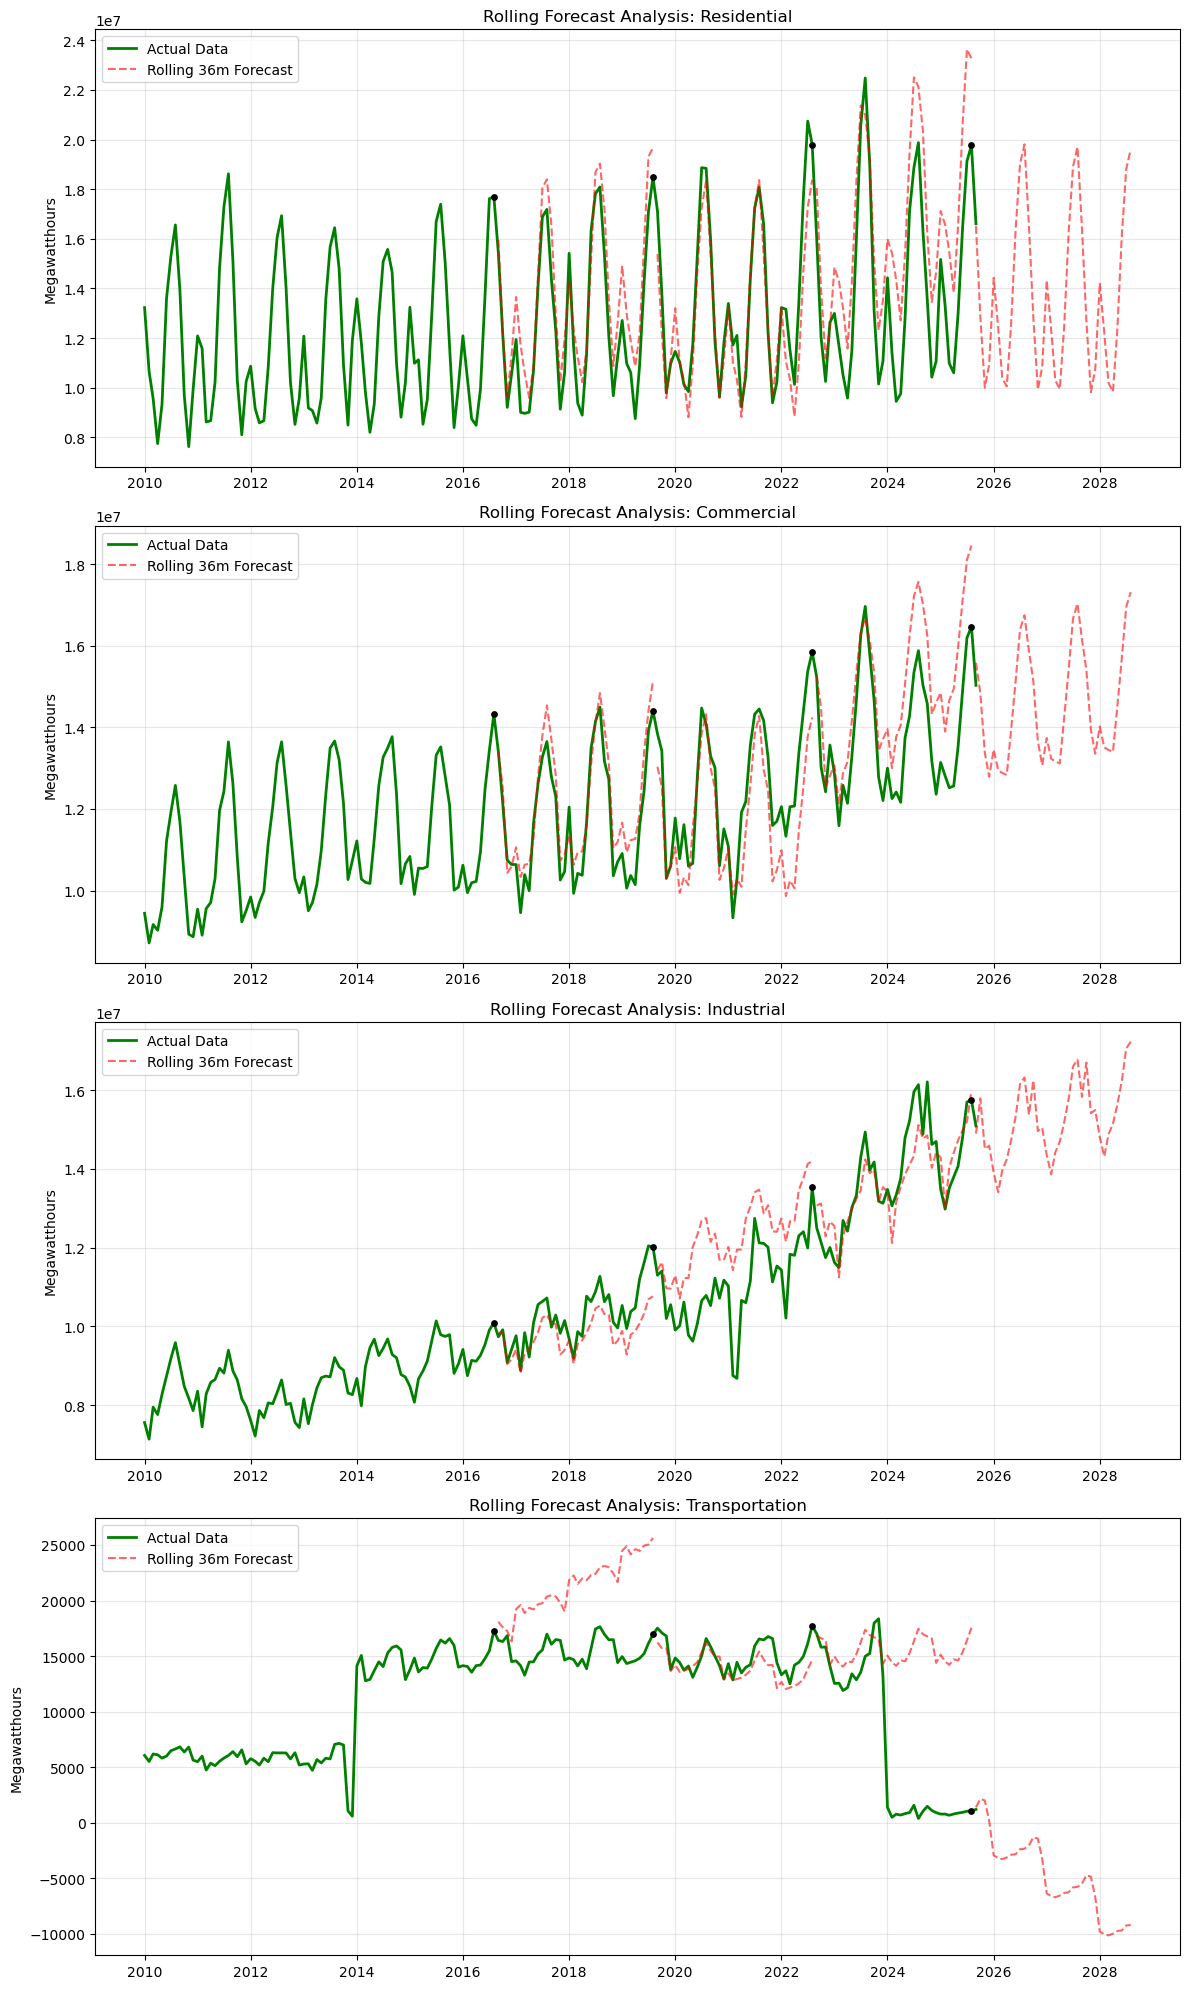

In [39]:

# ==========================================
# 1. PLOTTING FUNCTION
# ==========================================
def plot_sector_results(ax, sector_name, actual_series, forecasts):
    """
    Plots the actual history and overlays all rolling forecast lines.
    """
    # Plot Actuals
    ax.plot(actual_series.index, actual_series, color='green', linewidth=2, label='Actual Data')
    
    # Plot Rolling Forecasts
    first_fc = True
    for item in forecasts:
        fc_series = item['forecast_series']
        label = 'Rolling 36m Forecast' if first_fc else None
        ax.plot(fc_series.index, fc_series, color='red', linestyle='--', alpha=0.6, linewidth=1.5, label=label)
        
        # Dot at cutoff
        ax.scatter(item['cutoff_date'], actual_series.loc[item['cutoff_date']], color='black', s=15, zorder=5)
        
        first_fc = False

    ax.set_title(f"Rolling Forecast Analysis: {sector_name.title()}")
    ax.set_ylabel("Megawatthours")
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

# ==========================================
# 2. EXECUTION (Unwrapped for Notebook)
# ==========================================

df = load_and_prep_data(FILE_PATH)

sectors = SECTORS

all_export_data = []

# Create Figure
fig, axes = plt.subplots(len(sectors), 1, figsize=(12, 5 * len(sectors)), sharex=False)
if len(sectors) == 1: axes = [axes] 


for i, (sector_name, col_name) in enumerate(sectors.items()):
    
    series = df[col_name].dropna()
    
    forecasts = get_rolling_predictions(
        series, 
        TRAIN_WINDOW, 
        FORECAST_HORIZON, 
        STEP_SIZE
    )
    
    for f in forecasts:
        cutoff_date = f['cutoff_date']
        pred_series = f['forecast_series']
        
        for pred_date, value in pred_series.items():
            all_export_data.append({
                'Sector': sector_name,
                'Cutoff_Date': cutoff_date,   # When the forecast was made
                'Prediction_Date': pred_date, # The future month being predicted
                'Forecast_Value': value       # The predicted MWh
            })
    
    plot_sector_results(axes[i], sector_name, series, forecasts)

export_df = pd.DataFrame(all_export_data)
export_filename = 'TX_rolling_forecast_values.csv'
#export_df.to_csv(export_filename, index=False)

plt.tight_layout()
plt.show()

In [40]:
df

,Unnamed: 0,year,month,state,data_status,residential_revenue_thousand_dollars,residential_sales_megawatthours,residential_customers_count,residential_price_cents_kwh,commercial_revenue_thousand_dollars,...,industrial_customers_count,industrial_price_cents_kwh,transportation_revenue_thousand_dollars,transportation_sales_megawatthours,transportation_customers_count,transportation_price_cents_kwh,total_revenue_thousand_dollars,total_sales_megawatthours,total_customers_count,total_price_cents_kwh
period,,,,,,,,,,,,,,,,,,,,,
2010-01-01,9631,2010,1.0,TX,Final,1482796.0,13226950.0,9426432.0,11.21,881782.0,...,123914.0,6.41,599.00,6058.00,3.0,9.89,2850056.0,30235389.0,11018124.0,9.43
2010-02-01,9580,2010,2.0,TX,Final,1208908.0,10656540.0,9442046.0,11.34,829689.0,...,123697.0,6.68,531.00,5512.00,3.0,9.63,2516055.0,26517691.0,11020940.0,9.49
2010-03-01,9529,2010,3.0,TX,Final,1099768.0,9557712.0,9491323.0,11.51,879323.0,...,124858.0,6.56,592.00,6189.00,3.0,9.57,2501621.0,26681477.0,11079822.0,9.38
2010-04-01,9478,2010,4.0,TX,Final,939081.0,7745987.0,9495461.0,12.12,849268.0,...,126661.0,6.48,589.00,6111.00,3.0,9.64,2292337.0,24541760.0,11079906.0,9.34
2010-05-01,9427,2010,5.0,TX,Final,1115313.0,9338767.0,9498989.0,11.94,887693.0,...,127017.0,6.40,586.00,5815.00,3.0,10.08,2533080.0,27222961.0,11078341.0,9.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-01,247,2025,5.0,TX,Preliminary,2009551.6,12975735.0,12680933.0,15.49,1203890.6,...,395651.0,6.63,33.73,869.51,3.0,3.88,4146770.7,40568903.0,14604052.0,10.22
2025-06-01,196,2025,6.0,TX,Preliminary,2505083.5,16448338.0,12731147.0,15.23,1281589.9,...,406727.0,6.34,36.05,936.69,3.0,3.85,4725264.4,46151720.0,14663263.0,10.24
2025-07-01,145,2025,7.0,TX,Preliminary,2938121.0,19128723.0,12745852.0,15.36,1462019.2,...,410176.0,6.60,38.97,1032.58,3.0,3.77,5436155.5,51021948.0,14682811.0,10.65


In [41]:
predictions_grouped = export_df.groupby(['Cutoff_Date', 'Sector'])

In [42]:
predictions_dict = {
    (cutoff, sector): group.copy()
    for (cutoff, sector), group in predictions_grouped
}

In [43]:
predictions_dict.keys()

dict_keys([(Timestamp('2016-08-01 00:00:00'), 'commercial'), (Timestamp('2016-08-01 00:00:00'), 'industrial'), (Timestamp('2016-08-01 00:00:00'), 'residential'), (Timestamp('2016-08-01 00:00:00'), 'transportation'), (Timestamp('2019-08-01 00:00:00'), 'commercial'), (Timestamp('2019-08-01 00:00:00'), 'industrial'), (Timestamp('2019-08-01 00:00:00'), 'residential'), (Timestamp('2019-08-01 00:00:00'), 'transportation'), (Timestamp('2022-08-01 00:00:00'), 'commercial'), (Timestamp('2022-08-01 00:00:00'), 'industrial'), (Timestamp('2022-08-01 00:00:00'), 'residential'), (Timestamp('2022-08-01 00:00:00'), 'transportation'), (Timestamp('2025-08-01 00:00:00'), 'commercial'), (Timestamp('2025-08-01 00:00:00'), 'industrial'), (Timestamp('2025-08-01 00:00:00'), 'residential'), (Timestamp('2025-08-01 00:00:00'), 'transportation')])

In [44]:
predictions_grouped

In [45]:
print(forecasts[0])

{'cutoff_date': Timestamp('2016-08-01 00:00:00'), 'forecast_series': 2016-09-01    18087.850182
2016-10-01    17577.274501
2016-11-01    17241.356910
2016-12-01    16328.169330
2017-01-01    19222.201383
2017-02-01    19599.352406
2017-03-01    18873.141153
2017-04-01    19339.203891
2017-05-01    19191.430921
2017-06-01    19660.498621
2017-07-01    19756.868203
2017-08-01    20351.359213
2017-09-01    20475.214251
2017-10-01    20358.621433
2017-11-01    19799.360560
2017-12-01    19012.783111
2018-01-01    21835.041681
2018-02-01    22252.880071
2018-03-01    21503.603728
2018-04-01    21982.741738
2018-05-01    21827.556582
2018-06-01    22300.826144
2018-07-01    22394.813751
2018-08-01    22990.655068
2018-09-01    23113.744636
2018-10-01    22997.585753
2018-11-01    22438.078888
2018-12-01    21651.640888
2019-01-01    24473.820407
2019-02-01    24891.703610
2019-03-01    24142.401863
2019-04-01    24621.554274
2019-05-01    24466.360954
2019-06-01    24939.635144
2019-07-01   

In [46]:


# df = pd.read_csv("TX_consumption.csv")

# df["period"] = pd.to_datetime(
#     dict(year=df["year"], month=df["month"].astype(int), day=1)
# )

# df = df.sort_values("period")

# train_df = df[df["period"] <= "2022-12-01"].copy()
# test_df  = df[df["period"] >  "2022-12-01"].copy()

# print("Train range:", train_df["period"].min(), "→", train_df["period"].max())
# print("Test  range:", test_df["period"].min(), "→", test_df["period"].max())
# print("Train rows:", len(train_df), "Test rows:", len(test_df))

# # Target columns per sector
# sector_targets = {
#     "residential":    "residential_sales_megawatthours",
#     "commercial":     "commercial_sales_megawatthours",
#     "industrial":     "industrial_sales_megawatthours",
#     "transportation": "transportation_sales_megawatthours",
# }

# # ========== 2) HELPER: FIT & FORECAST UNIVARIATE SARIMA ==========

# def fit_sarima(series_train, steps,
#                order=(1, 1, 1),
#                seasonal_order=(0, 1, 1, 12)):
#     """
#     Fit SARIMA on series_train and forecast 'steps' months ahead.
#     Returns (result_obj, forecast_obj).
#     """
#     model = SARIMAX(
#         series_train,
#         order=order,
#         seasonal_order=seasonal_order,
#         enforce_stationarity=False,
#         enforce_invertibility=False,
#     )
#     res = model.fit(disp=False)
#     fc = res.get_forecast(steps=steps)
#     return res, fc

# def rmse(y_true, y_pred):
#     diff = y_pred - y_true
#     return np.sqrt(np.mean(diff**2))

# def mape(y_true, y_pred, eps=1e-9):
#     mask = np.abs(y_true) > eps
#     return np.mean(np.abs((y_pred[mask] - y_true[mask]) / y_true[mask])) * 100.0

# # ========== 3) MAIN LOOP OVER SECTORS ==========

# all_forecasts = []   # rows: one per (period, sector)
# metrics = []         # summary metrics per sector

# for sector_name, col in sector_targets.items():
#     print("\n=== Sector:", sector_name, "===")

#     # Build train/test series for this target
#     y_train = (
#         train_df.set_index("period")[col]
#         .astype(float)
#         .asfreq("MS")  # monthly start frequency
#     )
#     y_test = (
#         test_df.set_index("period")[col]
#         .astype(float)
#         .asfreq("MS")
#     )

#     # Forecast horizon = length of test set (3-year-like)
#     steps = len(y_test)

#     # Fit SARIMA(1,1,1)x(0,1,1,12) on TRAIN ONLY
#     res, fc = fit_sarima(
#         series_train=y_train,
#         steps=steps,
#         order=(1, 1, 1),
#         seasonal_order=(0, 1, 1, 12),
#     )

#     fc_mean = fc.predicted_mean
#     fc_ci   = fc.conf_int(alpha=0.05)
#     lower = fc_ci.iloc[:, 0]
#     upper = fc_ci.iloc[:, 1]

#     fc_mean = fc_mean.reindex(y_test.index)
#     lower   = lower.reindex(y_test.index)
#     upper   = upper.reindex(y_test.index)

#     sector_rmse = rmse(y_test.values, fc_mean.values)
#     sector_mape = mape(y_test.values, fc_mean.values)
#     print(f"RMSE  (test): {sector_rmse:,.2f}")
#     print(f"MAPE% (test): {sector_mape:5.2f}")

#     metrics.append({
#         "sector": sector_name,
#         "rmse": sector_rmse,
#         "mape_percent": sector_mape,
#     })

#     for date in y_test.index:
#         all_forecasts.append({
#             "period": date,
#             "sector": sector_name,
#             "forecast_megawatthours": float(fc_mean.loc[date]),
#             "lower_95": float(lower.loc[date]),
#             "upper_95": float(upper.loc[date]),
#             "actual_megawatthours": float(y_test.loc[date]),
#         })

# forecast_df = pd.DataFrame(all_forecasts).sort_values(["sector", "period"])
# metrics_df  = pd.DataFrame(metrics).set_index("sector")

# print("\n=== Metrics per sector ===")
# print(metrics_df)

# print("\nForecast head:")
# print(forecast_df.head())


# sectors = list(sector_targets.keys())

# fig, axes = plt.subplots(len(sectors), 1, figsize=(12, 3*len(sectors)), sharex=True)

# cutoff = pd.Timestamp("2023-01-01")

# for i, s in enumerate(sectors):
#     ax = axes[i]

#     col = sector_targets[s]

#     # full series for this sector
#     y_all = (
#         df.set_index("period")[col]
#         .astype(float)
#         .asfreq("MS")
#     )

#     # train <= 2022-12, test >= 2023-01
#     y_train = y_all[y_all.index < cutoff]
#     y_test  = y_all[y_all.index >= cutoff]

#     # last 4 years of training
#     train_plot = y_train.iloc[-48:] if len(y_train) > 48 else y_train

#     # forecasts from forecast_df
#     fc = (
#         forecast_df[forecast_df["sector"] == s]
#         .set_index("period")["forecast_megawatthours"]
#         .asfreq("MS")
#     )

#     # plotting
#     ax.plot(train_plot.index, train_plot, label="Training Data (<= 2022)", color="blue")
#     ax.plot(y_test.index, y_test, label="Actual Data (2023+)", color="green")
#     ax.plot(fc.index, fc, label="Forecast (Model Prediction)", 
#             color="red", linestyle="--", linewidth=2)

#     # vertical cutoff
#     ax.axvline(cutoff, color="black", linestyle=":", alpha=0.5, label="Cutoff")

#     ax.set_title(f"{s.title()} Backtest (Train <= 2022)")
#     ax.grid(True, alpha=0.3)

#     # avoid duplicate legend labels across sectors
#     if i == 0:
#         ax.legend(loc="upper left")

# plt.tight_layout()

In [47]:
# forecast_df
